In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import root_scalar
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                                  RANSACRegressor, TheilSenRegressor)

In [2]:
from bokeh.layouts import layout
from bokeh.models import Slider, CustomJS
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook

In [3]:
from matplotlib.pyplot import step

output_notebook()
p0 = figure(height=400, width=800)
p1 = figure(height=300, width=400)
p2 = figure(height=300, width=400)
p3 = figure(height=220, width=800)
p4 = figure(height=300, width=400)
p5 = figure(height=300, width=400)
p6 = figure(height=300, width=800)
p7 = figure(height=220, width=800)


Loading BokehJS ...

In [4]:
def find_fiber(edges, **args):
    # global p1
    y, x = edges.shape
    num = np.tile(np.linspace(0, 1, y), (x, 1)).T
    if args.get('plot') == True:
        p1.image(image=[edges], x=0, y=0, dw=1, dh=1, palette="Spectral11")
    edges = edges > 0
    s = np.sum(edges, axis=0)
    m = np.sum(edges * num, axis=0) / s
    st = np.std(edges * num, axis=0)
    std = np.median(st)
    # if args.get('plot') == True:
    #     plt.plot(st, 'o')
    #     plt.plot([0, x - 1], [std, std])
    #     plt.show()
    X = np.linspace(0, 1, x)
    bad = np.argwhere(np.isnan(m))
    X = np.delete(X, bad)
    m = np.delete(m, bad)
    ransac = RANSACRegressor(random_state=42).fit(X.reshape([-1, 1]), m)
    if args.get('plot') == True:
        pred = ransac.predict(X[[0, -1]].reshape([-1, 1]))
        p2.circle(X, m, size=5)
        p2.line([0, 1], pred, line_color='red')
    return float(ransac.estimator_.coef_), float(ransac.predict([[0]])), std


def turn_crop(im, alf, b, std, **args):
    w = args.get('width', 4)
    up = max(b, b + alf)
    down = min(b, b + alf)
    y, x = im.shape
    up = int(np.clip(up + w * std, 0, 1) * y)
    down = int(np.clip(down - w * std, 0, 1) * y)
    cr_im = im[down:up, :]
    y_new = cr_im.shape[0]
    M = cv2.getRotationMatrix2D([x / 2, y_new / 2],
                                np.arctan(alf * y / x) * 180 / np.pi, 1)
    rotated = cv2.warpAffine(cr_im,
                             M, [cr_im.shape[1], cr_im.shape[0]],
                             borderMode=cv2.BORDER_REPLICATE)
    y_min = int(y_new / 2 - w * std * y)
    y_max = int(y_new / 2 + w * std * y)
    rotated = rotated[y_min:y_max]
    if args.get('plot') == True:
        p3.image(image=[rotated],
                 x=0,
                 y=0,
                 dw=1,
                 dh=rotated.shape[0]/y,
                 palette="Spectral11")
        # plt.imshow(rotated)
        # plt.show()
    return rotated


def cuts(m, n):
    y, x = m.shape
    step = x / n
    b = np.ceil(np.arange(step, x, step)).astype(int)
    lis = np.split(m, b, axis=1)
    means = []
    for l in lis:
        means.append(l.mean(axis=1))
    return np.stack(means)


def fit(m, x):
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), m)
    pred = ransac.predict(x.reshape([-1, 1]))
    std = np.mean((pred - m)**2)
    return std, {'x': x[[0, -1]], 'y': pred[[0, -1]]}


class window_fit():
    def __init__(self, mas, w):
        self.mas = mas
        self.w = w
        self.x, self.y = mas.shape
        self.v = np.ones_like(mas) * float('-inf')
        self.Y = np.arange(self.y)
        self.boards = np.zeros([self.x, 2])

    def get(self, x, y):
        
        y -= self.w / 2
        x0 = math.floor(x)
        x1 = math.ceil(x)
        y0 = math.floor(y)
        y1 = math.ceil(y)
        s0 = self.calc(x0, y0)
        s1 = self.calc(x1, y1)
        s = s1 * (y - y0) + s0 * (1 - (y - y0))
        return s

    def calc(self, x, y):
        if self.v[x, y] == float('-inf'):
            s, p = fit(self.mas[x, y:y + self.w], self.Y[y:y + self.w])
            self.v[x, y] = math.log(s)
            return math.log(s)
        else:
            return self.v[x, y]

    def get_betwin(self, y0, y1):
        y0, y1 = min(y0, y1), max(y0, y1)
        y0 = max(0, math.ceil(y0))
        y1 = min(self.y - 1, math.floor(y1))
        return np.arange(y0, y1 + 1)

    def get_mas(self, x):
        X = np.argwhere(self.v[x] != float('-inf'))
        Y = self.v[x, X]
        X = X + self.w / 2
        return X.flatten(), Y.flatten()

    def calc_gerd(self, n):
        Y = np.ceil(np.linspace(0, self.y - self.w - 1, n)).astype(int)
        for x in range(self.x):
            for y in Y:
                self.calc(x, y)

    def find_borders(self, kof):
        for x in range(self.x):
            p, val = self.get_mas(x)
            # plt.plot(p,val)
            # plt.show()
            ma = val.max()
            mi = val.min()
            tr = mi * kof + ma * (1 - kof)
            ind = np.argwhere(val > tr).flatten()
            b = [ind.min() - 1, ind.min()]
            # print(x,b)
            # print(x,p[b])
            y0 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            b = [ind.max(), ind.max() + 1]
            y1 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            self.boards[x, :] = [y0 + self.w / 2 - 0.5, y1 - self.w / 2 - 0.5]

In [5]:
import xarray as xr


def fit(m):
    dat = m.data
    x = m.coord['y']
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), dat)
    pred = ransac.predict(x.reshape([-1, 1]))
    std = np.mean((pred - m)**2)
    result = xr.DataArray(pred[[0, -1]], coords={'x': x[[0, -1]]})
    return std, result


class window_fit2:
    def __init__(self, mas, w, pixel_size, nx):

        self.fresh = xr.DataArray(mas,
                                  coords={
                                      'y': range(mas.shape[0]) * pixel_size,
                                      'x': range(mas.shape[1]) * pixel_size
                                  })
        self.x = mas.shape[1] * pixel_size
        self.y = mas.shape[0] * pixel_size
        self.cats(nx)
        self.w = w
        v_coord = self.fresh.y.sel(y=slice(w / 2, self.y - w / 2))
        self.v = [[
            self.count_window(x, y, w, self.mas) for x in self.fresh.x.data
        ] for y in v_coord.data]
        # v_dat = np.ones([len(v_coord), mas.shape[1]]) * float('-inf')
        # self.v = xr.DataArray(v_dat, coords={'x': self.fresh.x, 'y': v_coord})
        # self.Y = np.arange(self.y)
        self.boards = xr.DataArray(np.zeros([self.x, 2]),
                                   coords={
                                       'x': self.fresh.x,
                                       'border': ['up', 'down']
                                   })

    class count_window:
        def __init__(self, x, y, w, arr):
            self.x = x
            self.y = y
            self.w = w
            self.arr = arr
            self.result = None

        def __call__(self, fun=math.log):
            if self.result is None:
                s, p = fit(
                    self.arr.sel(x=self.x,
                                 y=slice(self.x - self.w / 2,
                                         self.x + self.w / 2)))
            return fun(self.result)

    def cuts(self, n):
        x_p = np.linspace(0, self.x, n, endpoint=False)
        dx = x_p[1] - x_p[0]
        mas = []
        for x in x_p:
            mas.append(self.fresh.sel(x=slice(x, x + dx)).mean('x'))
        self.mas = xr.concat(mas, 'x')
        self.mas.coords['x'] = x_p + dx / 2

    def get(self, x, y):
        p0 = self.mas.sel(x=x, y=y, method='ffill')
        p1 = self.mas.sel(x=x, y=y, method='bfill')

        y -= self.w / 2
        x0 = math.floor(x)
        x1 = math.ceil(x)
        y0 = math.floor(y)
        y1 = math.ceil(y)
        s0 = self.calc(x0, y0)
        s1 = self.calc(x1, y1)
        s = s1 * (y - y0) + s0 * (1 - (y - y0))
        return s

    def calc(self, x, y):

        if self.v[x, y] == float('-inf'):
            s, p = fit(self.mas[x, y:y + self.w], self.Y[y:y + self.w])
            self.v[x, y] = math.log(s)
            return math.log(s)
        else:
            return self.v[x, y]

    def get_betwin(self, y0, y1):
        y0, y1 = min(y0, y1), max(y0, y1)
        y0 = max(0, math.ceil(y0))
        y1 = min(self.y - 1, math.floor(y1))
        return np.arange(y0, y1 + 1)

    def get_mas(self, x):
        X = np.argwhere(self.v[x] != float('-inf'))
        Y = self.v[x, X]
        X = X + self.w / 2
        return X.flatten(), Y.flatten()

    def calc_gerd(self, n):
        Y = np.ceil(np.linspace(0, self.y - self.w - 1, n)).astype(int)
        for x in range(self.x):
            for y in Y:
                self.calc(x, y)

    def find_borders(self, kof):
        for x in range(self.x):
            p, val = self.get_mas(x)
            # plt.plot(p,val)
            # plt.show()
            ma = val.max()
            mi = val.min()
            tr = mi * kof + ma * (1 - kof)
            ind = np.argwhere(val > tr).flatten()
            b = [ind.min() - 1, ind.min()]
            # print(x,b)
            # print(x,p[b])
            y0 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            b = [ind.max(), ind.max() + 1]
            y1 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            self.boards[x, :] = [y0 + self.w / 2 - 0.5, y1 - self.w / 2 - 0.5]

In [111]:
class count_window:
    def __init__(self, mas, w) -> None:
        self.ymax = mas.y.max() - w/2
        self.ymin = mas.y.min() + w/2
        self.xmax = mas.x.max()
        self.xmin = mas.x.min()
        self.w = w
        y = mas.y.sel(y=slice(self.ymin, self.ymax))
        points = {'x': mas.x, 'y': y}
        self.exist = xr.DataArray(np.zeros([len(mas.x),len(y)], dtype=bool), points)
        self.resalts = xr.DataArray()
        self.mas = mas
    def __call__(self, x, y, method='2p'):
        p0 = self.exist.sel(x=x,y=y, method='bfill').copy()
        p1 = self.exist.sel(x=x, y=y, method='ffill').copy()
        for p in [p0, p1]:
            if not p:
                self.exist = xr.where((self.exist.coords['x'] == p.coords['x']) &
                                  (self.exist.coords['y'] == p.coords['y']),
                                  100, self.exist)
            p.name = 'res'
            self.count(p)
            self.resalts =xr.merge(p, self.resalts)
            print(p)
            print(self.resalts)
        return self.resalts.interp(x=x, y=y)

    def count(self, p):
        x = p.coords['x']
        y = p.coords['y']
        sl = self.mas.sel(y=slice(y-self.w/2,y+self.w/2), x=x)
        std, line = fit(sl)
        p.data = std

In [300]:
class count_window2:
    def __init__(self, mas, w) -> None:
        self.ymax = mas.y.max() - w / 2
        self.ymin = mas.y.min() + w / 2
        self.xmax = mas.x.max()
        self.xmin = mas.x.min()
        self.w = w
        self.mas = mas
        self.win = xr.full_like(mas.sel(y=slice(self.ymin, self.ymax)), np.nan)
        # self.data = xr.Dataset({'mas': mas, 'win': win})

    def __call__(self, x, y, method='2p'):
        x = np.array(x).flatten()
        y = np.array(y).flatten()
        p1 = self.win.sel(x=x, y=y, method='bfill')
        p0 = self.win.sel(x=x, y=y, method='ffill')
        for p in [p0, p1]:
            if np.isnan(p):
                p.name = 'win'
                self.count(p)
                # self.resalts = xr.concat([self.resalts, p],'y')
                # self.resalts = p.combine_first(self.resalts)
                self.win = p.combine_first(self.win)
        # print('p1 \n', self.win.sel(x=x, y=y, method='bfill'))
        # print('p0 \n', self.win.sel(x=x, y=y, method='ffill'))
        if p0.y.data == p1.y.data:
            res = p0.data
        else:
            res = p1.data * (y - p0.y.data) + p0.data * (p1.y.data - y)
        return res

    def count(self, p):
        x = p.coords['x'][0]
        y = p.coords['y'][0]
        sl = self.mas.sel(y=slice(y - self.w / 2, y + self.w / 2), x=x)
        std, line = fit(sl)
        p.data[0, 0] = np.log(std)


In [301]:
def fit(m):
    dat = m.data
    x = m.coords['y'].data
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), dat)
    pred = ransac.predict(x.reshape([-1, 1]))
    std = np.mean((pred - m)**2)
    result = xr.DataArray(pred[[0, -1]], coords={'y': x[[0, -1]]})
    return std, result

In [302]:
def fit2(m):
    dat = m.data.T
    x = m.coords['y'].data
    print(dat.shape, x.shape)
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), dat)
    pred = ransac.predict(x.reshape([-1, 1]))
    print(pred.shape)
    std = np.mean((pred - dat)**2, axis=0)
    print(std.shape)
    # result = xr.DataArray(pred[[0, -1]], coords={'y': x[[0, -1]]})
    return std

In [303]:
def cuts(fresh, n):
    x_p = np.linspace(0, fresh.max().item(), n, endpoint=False)
    dx = x_p[1] - x_p[0]
    mas = []
    for x in x_p:
        mas.append(fresh.sel(x=slice(x, x + dx)).mean('x'))
    mas = xr.concat(mas, 'x')
    mas.coords['x'] = x_p + dx / 2
    return mas

In [304]:
def calc_gerd(wf, n):
    yp = np.linspace(wf.ymin, wf.ymax, n)
    p = wf.win.sel(y=yp, method='nearest')
    for x in p.x.data:
        for y in p.y.data:
            wf(x, y)

In [336]:
def find_borders(wf, kof):
    brd = xr.zeros_like(wf.win.x) * xr.DataArray([0, 0],
                                                 {'border': ['up', 'down']})
    for i, x in enumerate(wf.win.x.data):
        val = wf.win[{'x': i}]
        val = val.dropna('y')
        ma = np.nanmax(val)
        mi = np.nanmin(val)
        tr = mi * kof + ma * (1 - kof)
        top = val[val > tr]
        
        # print(ma, mi, tr)
        if p0 == wf.ymin:
            p0 = top.y[[0, 1]]
            tr = top[0]
        else:
            delt = 0.001
            print([p0.item() - delt, p0.item() + delt])
            p0 = val.y.sel(y=[p0.item() - delt,
                              p0.item() + delt],
                           method='ffill')
        # print(wf(x,p0[0]), wf(x,p0[1]))
        y0 = root_scalar(lambda y: wf(x, y) - tr,
                         method='brentq',
                         bracket=p0.data).root
        
        
        p1 = top.y.data[-1]
        if p1 == wf.ymax:
            p1 = top.y[[-2, -1]]
            tr = top[-1]
        else:
            delt = 0.001
            p1 = val.y.sel(y=[p1.item() - delt,
                              p1.item() + delt],
                           method='bfill')
        # print(wf(x, p0[0]), wf(x, p0[1]))
        y1 = root_scalar(lambda y: wf(x, y) - tr,
                         method='brentq',
                         bracket=p1.data).root

        brd[{'x': i}] = [y0 + wf.w / 2, y1 - wf.w / 2]
    return brd

In [330]:
pixel_size = 1.82
im = cv2.imread('data/fiberTest/im9.0.jpg', cv2.IMREAD_GRAYSCALE)
p0.image(image=[im], x=0, y=0, dw=1, dh=1, palette="Spectral11")
y, x = im.shape
kof = 20
tr = 100
im4 = cv2.resize(im, dsize=(x // kof, y // kof))
edges = cv2.Canny(im4, tr, tr, L2gradient=True)
alf, b, std = find_fiber(edges, plot=True)
rotated = turn_crop(im, alf, b, std, width=1, plot=True)

/tmp/ipykernel_107801/1236483953.py:9: RuntimeWarning: invalid value encountered in divide
  m = np.sum(edges * num, axis=0) / s


In [331]:
fresh = xr.DataArray(rotated,
                     coords={
                         'y': np.arange(rotated.shape[0]) * pixel_size,
                         'x': np.arange(rotated.shape[1]) * pixel_size
                     })

x = rotated.shape[1] * pixel_size
y = rotated.shape[0] * pixel_size

In [332]:
mas = cuts(fresh, 10)

In [333]:
w = 20 * pixel_size
wf = count_window2(mas,w)

In [334]:
calc_gerd(wf,20)

In [337]:
find_borders(wf, 0.5)

9.944297609927284 -1.5884418050146423 4.177927902456321
132.86
[132.859, 132.86100000000002]
<xarray.DataArray 'y' (y: 8)>
array([132.86, 134.68, 152.88, 172.9 , 192.92, 211.12, 231.14, 251.16])
Coordinates:
  * y        (y) float64 132.9 134.7 152.9 172.9 192.9 211.1 231.1 251.2
    x        float64 12.75
[[2.95350469]] [[5.27423746]]
[[2.95350469]] [[5.27423746]]
9.820638538598097 -0.9522989148224794 4.434169811887808
134.68
[134.679, 134.681]
<xarray.DataArray 'y' (y: 7)>
array([134.68, 152.88, 172.9 , 192.92, 211.12, 231.14, 251.16])
Coordinates:
  * y        (y) float64 134.7 152.9 172.9 192.9 211.1 231.1 251.2
    x        float64 38.25
[[-0.71991047]] [[5.83151855]]
[[-0.71991047]] [[5.83151855]]
10.055544868001002 -0.701686395134367 4.676929236433318
134.68
[134.679, 134.681]
<xarray.DataArray 'y' (y: 7)>
array([134.68, 152.88, 172.9 , 192.92, 211.12, 231.14, 251.16])
Coordinates:
  * y        (y) float64 134.7 152.9 172.9 192.9 211.1 231.1 251.2
    x        float64 63.75
[[0.

<xarray.DataArray (x: 10, border: 2)>
array([[149.24      , 234.1626585 ],
       [149.90336309, 234.10789879],
       [149.56910564, 234.0739937 ],
       [150.14145887, 233.90730836],
       [150.13935382, 234.64072926],
       [149.19763524, 234.67992216],
       [152.88      , 232.96      ],
       [152.88      , 232.96      ],
       [150.89327266, 234.50113748],
       [150.65735276, 234.34886571]])
Coordinates:
  * x        (x) float64 12.75 38.25 63.75 89.25 ... 165.8 191.2 216.8 242.2
  * border   (border) <U4 'up' 'down'

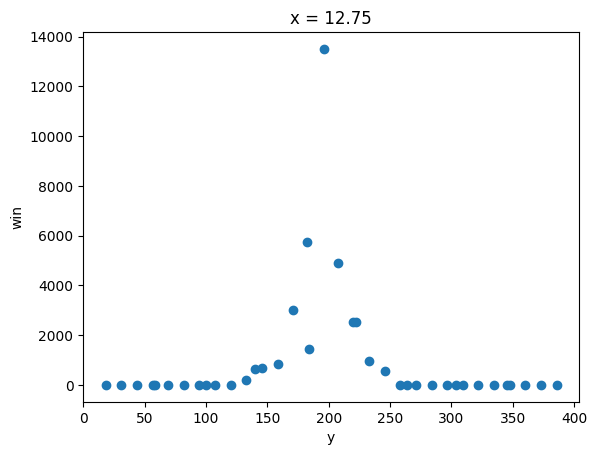

In [261]:
wf.win.sel(x=10, method='nearest').plot.line("o")

In [230]:
wf(x=38.25, y= 200)

<xarray.DataArray ()>
array(6418.12046639)
Coordinates:
    x        float64 38.25
<xarray.DataArray ()>
array(2117.99672844)
Coordinates:
    x        float64 38.25


array([[4714.77879336]])

In [17]:
wf.exist

<xarray.DataArray (x: 10, y: 211)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x        (x) float64 12.75 38.25 63.75 89.25 ... 165.8 191.2 216.8 242.2
  * y        (y) float64 10.92 12.74 14.56 16.38 ... 387.7 389.5 391.3 393.1

In [5]:
pixel_size = 1.82
im = cv2.imread('data/fiberTest/im9.0.jpg', cv2.IMREAD_GRAYSCALE)
p0.image(image=[im], x=0, y=0, dw=1, dh=1, palette="Spectral11")
y, x = im.shape
kof = 20
tr = 100
im4 = cv2.resize(im, dsize=(x // kof, y // kof))
edges = cv2.Canny(im4, tr, tr, L2gradient=True)
alf, b, std = find_fiber(edges, plot=True)
rotated = turn_crop(im, alf, b, std, width=1, plot=True)
mas = cuts(rotated, 30)
# p4.line(np.linspace(0,1,mas.shape[1]),mas[0])
wf = window_fit(mas, 20)
wf.calc_gerd(20)
wf.find_borders(0.5)

/tmp/ipykernel_39446/3309256138.py:9: RuntimeWarning: invalid value encountered in divide
  m = np.sum(edges * num, axis=0) / s


In [6]:
p4 = figure(height=300, width=400)
p5 = figure(height=300, width=400)
p6 = figure(height=300, width=800)
p7 = figure(height=220, width=800)
x = 20
y0 = wf.boards[x, 0]
y1 = wf.boards[x, 1]
ins = wf.mas[x, wf.get_betwin(y0, y1)]
ma = ins.max()
mi = ins.min()
vals = [mi, ma, ma, mi, mi]
points = [y0, y0, y1, y1, y0]
p4.line(points, vals, line_color='red')
p4.circle(wf.Y, wf.mas[x], size=5)

X, Y = wf.get_mas(x)
vals = [wf.get(x, y0 - wf.w / 2 + 0.5), wf.get(x, y1 + wf.w / 2 + 0.5)]
points = [y0 - wf.w / 2 + 0.5, y1 + wf.w / 2 + 0.5]
vals = [wf.get(x, points[0]), wf.get(x, points[1])]
p5.line(X, Y)
p5.circle(X, Y)
p5.line(points, vals, line_color='red')

X = np.linspace(0,1,wf.boards.shape[0])
p6.line(X, wf.boards[:, 0])
p6.line(X, wf.boards[:, 1])
p7.line(X, wf.boards[:, 1] - wf.boards[:, 0])

GlyphRenderer(id='1469', ...)

In [7]:
std1, point1 = fit(wf.boards[:,0], X)
std2, point2 = fit(wf.boards[:, 1], X)
p6.line([0, 1], point1['y'], line_color='red')
p6.line([0,1], point2['y'],line_color='red')
p7.line([0, 1], point2['y'] - point1['y'], line_color='red')

GlyphRenderer(id='1489', ...)

In [8]:
p = layout([[p0], [p1, p2], [p3], [p4, p5],[p6],[p7]])
show(p)

In [9]:
output_file("line1.html")
save(p)

'/home/korbash/Desktop/projects/fiber_thick/line1.html'